---
title: Decision Trees (from Spring 2025)
---

::: {note} Learning Outcomes
:class: dropdown
- Understand how to generate a decision tree
- Implement decision tree using `sklearn`
- Understand ways to improve decision trees, including random forests
:::

In [2]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In our second pass of the data science lifecycle, we've introduced new tools for data processing and exploratory data analysis. Now let's turn our attention to modeling. Today, we will introduce a new model called decision trees.

## Multi-class Classification

In our discussion about logistics regression, we mainly focused on the task of "binary classification" where we try to distinguish between two classes of labels (e.g., "spam" or "ham"). In real life though, we often have multi-class labels. For example, the Fashion-MNIST dataset we worked with last week have multiple classes of clothing items. How would we classify this kind of data?

As an example, let's consider a dataset about the iris flowers. The dataset consists of 150 flower measurements from 3 different species: setosa, versicolor, and virginica. For each, we have measurements of the flower's `“petal length”`, `“petal width”`, `“sepal length”`, and `“sepal width”`.

In [3]:
iris_data = pd.read_csv("data/iris.csv")
iris_data.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
88,5.6,3.0,4.1,1.3,versicolor
41,4.5,2.3,1.3,0.3,setosa
119,6.0,2.2,5.0,1.5,virginica
25,5.0,3.0,1.6,0.2,setosa
18,5.7,3.8,1.7,0.3,setosa


The goal today is to use these four measurements to try and predict the `species` of the iris flower.

Let's see how we can use logistic regression to classify this dataset with three classes. To do this, we will use the petal measurements: `petal_length` and `petal_width`:

In [4]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(multi_class = 'ovr')
logistic_regression_model = logistic_regression_model.fit(iris_data[["petal_length", "petal_width"]], 
                                                          iris_data["species"])

Notice when constructing the classifier, we specified `multi_class = 'ovr'`. 

`ovr` means "one-vs.-rest", which means `sklearn` trains three logistic regression binary classifiers:

- Classifier 1: Setosa or not.
- Classifier 2: Versicolor or not.
- Classifier 3: Virginica or not.

Then the `model.predict()` function will output the classifier that returns the highest probability:

In [5]:
logistic_regression_model.predict([[1.4, 0.2]])

array(['setosa'], dtype=object)

We can also visualize the decision boundary of this classifier. As we can see, each of three classifiers still has linear decision boundaries, but there are now three lines instead of 1.

````{dropdown} Click to see the code
```python
from matplotlib.colors import ListedColormap
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 7, 0.02),
                     np.arange(0, 2.8, 0.02))

Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "petal_length", y="petal_width", hue="species")
plt.xlim(0, 7);
plt.ylim(0, 2.8);
```

````

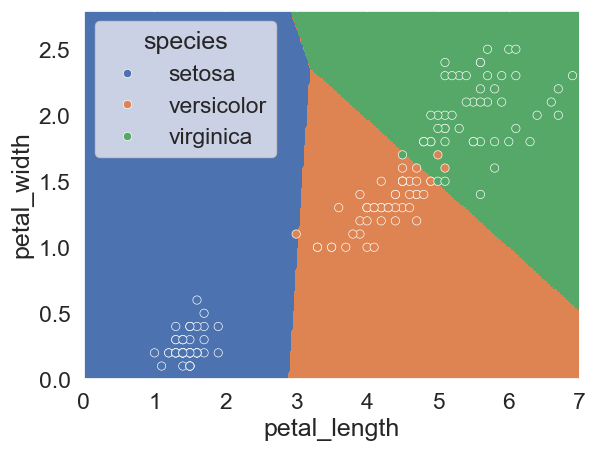

In [6]:
from matplotlib.colors import ListedColormap
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 7, 0.02),
                     np.arange(0, 2.8, 0.02))

Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "petal_length", y="petal_width", hue="species")
plt.xlim(0, 7);
plt.ylim(0, 2.8);

It turns out there are other (arguably) better models to use when it comes to multi-class classification.

In Data 100 so far, we've been talking about linear models. In Linear regression, the output is the weighted sum of the features. In logistic regression, the output is $\sigma$(the weighted sum of the features). 

Today, we are going into the territory of non-linear models. There are many non-linear models, decision tree is one of them.

## Decision Trees, conceptually

A decision tree is simply a tree of questions that must be answered in a sequence to yield a predicted classification. For example, below is a classifier for animals. It starts by asking how many legs the animal has. If the answer is no, we immediately say snake. If the answer is four, the model is not quite sure, so we must ask an additional question: does it purr?  If the answer is yes, the animal is a cat; and if the answer is no, the animal is a dog. The other possibility is that the number of legs was two, in that case we have up to two additional questions we may need to ask before eventually deciding if it is a kangaroo, human, or parrot. Obviously this decision tree does not cover all animals. In principle, with the right sequence of questions, we could build a giant decision tree that could differentiate a vast number of animals.

```{image} images/animal_tree.png
:alt: Example of a decision tree
:width: 600
```

For our iris dataset, we can come up with a decision tree just by looking at the points. It's important to note in the following decision tree we use multiple features in a single node to make the tree simpler, but in reality decision tree will only make a split based on one feature at a time. We will see an example of an actual decision tree in the next section.

```{image} images/manual_tree.png
:alt: Example of a decision tree on the iris data
:width: 600
```

Just by looking at the tree, it seems we reached 100% accuracy on this dataset. However, this should call for some concerns about potential overfitting.

### Decision Trees in `sklearn`

We can implement a decision tree easily using `sklearn`. Like other models we've been working with in this class so far, we would create an instance of the model, fit it on our training data, and use it to make predictions.

In [7]:
from sklearn import tree
decision_tree_model = tree.DecisionTreeClassifier(criterion='entropy')
decision_tree_model = decision_tree_model.fit(iris_data[["petal_length", "petal_width"]], iris_data["species"])

You might noticed that we specified `criterion = 'entropy'` when instantiating the model. We will talk more about "entropy" in a later section.

We can use the fitted decision tree model to predict four random points in our original data:

In [8]:
four_random_rows = iris_data.sample(4)
four_random_rows

,sepal_length,sepal_width,petal_length,petal_width,species
15,5.7,4.4,1.5,0.4,setosa
0,5.1,3.5,1.4,0.2,setosa
112,6.8,3.0,5.5,2.1,virginica
86,6.7,3.1,4.7,1.5,versicolor


In [9]:
decision_tree_model.predict(four_random_rows[["petal_length", "petal_width"]])

array(['setosa', 'setosa', 'virginica', 'versicolor'], dtype=object)

We can also visualize how the decision tree is constructed using a package called `GraphViz`. 

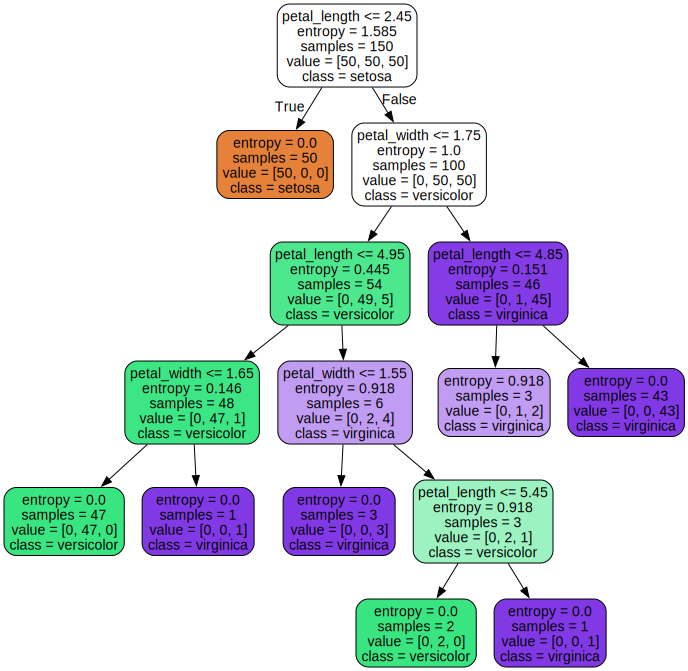

In [10]:
import graphviz
dot_data = tree.export_graphviz(decision_tree_model, out_file=None, 
                      feature_names=["petal_length", "petal_width"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
graph = graphviz.Source(dot_data)
graph

In each box/node, we see:

- The decision rule applied to that node.
- The entropy at that node (more later).
- The number of samples that remain after applying all of the rules above this node.
- The number of samples that remain in each class.
- The most likely class. If there is a tie, this is the class that comes first.

This visualization allows us to see exactly how the decision tree classifies each point. For example, if the `petal_length` of an iris flower is less than or equal to 1.75, we would classify it as `setosa`.

Like with the logistic regression model earlier, we can visualize the decision boundary of this tree.

````{dropdown} Click to see the code
:open: false
```python
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 7, 0.02),
                     np.arange(0, 2.8, 0.02))

Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "petal_length", y="petal_width", hue="species");
```

````

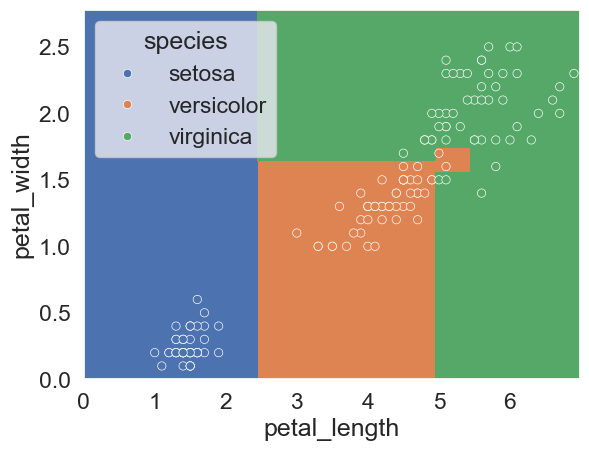

In [12]:
from matplotlib.colors import ListedColormap
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 7, 0.02),
                     np.arange(0, 2.8, 0.02))

Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "petal_length", y="petal_width", hue="species");

Decision tree has nonlinear boundary, and appears to get 100% accuracy. But did we actually get 100% accuracy? Let's check!

### Evaluating Tree Accuracy

To get the accuracy of a decision tree, we use the `accuracy_score` method implemented in `sklearn`.

In [13]:
from sklearn.metrics import accuracy_score
predictions = decision_tree_model.predict(iris_data[["petal_length", "petal_width"]])
accuracy_score(predictions, iris_data["species"])

0.9933333333333333

Hmm, it looks like we didn't get a perfect accuracy on the dataset. What happened?

To understand why, let's look back at the decision tree from earlier. In particular, let's look at one particular node, zoomed in on the right.

```{figure} images/problematic_node.png
---
width: 300px
name: problematic-node
alt: A node where decision tree failed
---
```

It looks like this node has three samples yet to be classified, with 1 versicolor and 2 virginicas, but the decision tree stopped here without splitting any further. This results in us classifying the one versicolor wrong.

Why did the decision tree stop? Let's check these three points by following the decision tree.

In [14]:
iris_data[(iris_data["petal_length"]> 2.45)&(iris_data["petal_width"]> 1.75)&(iris_data["petal_length"]<=4.85)]

,sepal_length,sepal_width,petal_length,petal_width,species
70,5.9,3.2,4.8,1.8,versicolor
126,6.2,2.8,4.8,1.8,virginica
138,6.0,3.0,4.8,1.8,virginica


It turns out, because we only used `petal_length` and `petal_width` to fit the decision tree, and these three points have the exact same measurements for `petal_length` and `petal_width`, decision tree was not able to come up with a decision rule to distinguish these three data points!

In general, decision trees (when unrestricted) will always have a perfect accuracy on the training data, **except** when there are samples from different categories with the exact same features. For example, if the versicolor above has a `petal_length` of 4.8001, we’d have 100% training accuracy.

Again, this tendency for perfect accuracy should give us concern about overfitting. As a result of trying to perfectly fit the training data, decision tree models are extremely sensitive to new data points and therefore have high variance.

### Overfitting Tree Example

Let's see an example where a decision tree clearly overfits.

Instead of the `petal` measurements, let's use the `sepal` measurements to train the decision tree. Here's a scatterplot of the dataset with the `sepal` measurements. We can see the virginicas are much more intertwined with versicolors, compared to the plot with the `petal` measurements.

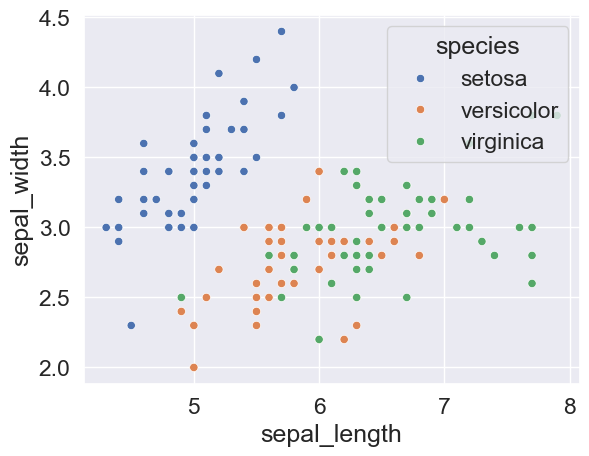

In [15]:
sns.scatterplot(data = iris_data, x = "sepal_length", y="sepal_width", hue="species", legend=True);

The decision tree fitted with these two features is very complex, as visualized below. We can see that the tree makes some extremely specific decision rules trying to perfectly capture the details in the dataset.

````{dropdown} Click to see the code
:open: false
```python
sepal_decision_tree_model = tree.DecisionTreeClassifier(criterion="entropy")
sepal_decision_tree_model = decision_tree_model.fit(iris_data[["sepal_length", "sepal_width"]], iris_data["species"])
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(4, 8, 0.02),
                     np.arange(1.9, 4.5, 0.02))

Z_string = sepal_decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "sepal_length", y="sepal_width", hue="species", legend=False);
```

````

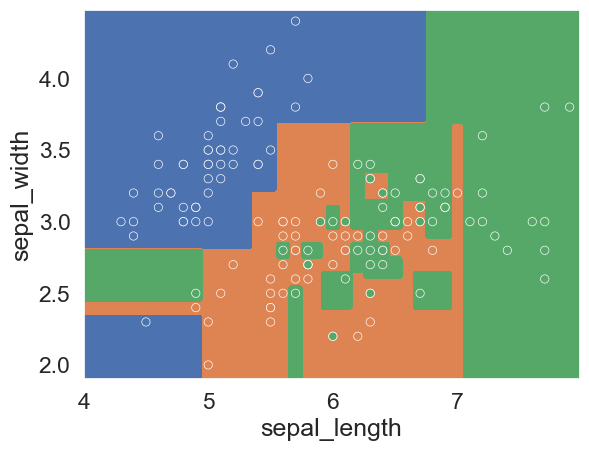

In [17]:
sepal_decision_tree_model = tree.DecisionTreeClassifier(criterion="entropy")
sepal_decision_tree_model = decision_tree_model.fit(iris_data[["sepal_length", "sepal_width"]], iris_data["species"])
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(4, 8, 0.02),
                     np.arange(1.9, 4.5, 0.02))

Z_string = sepal_decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "sepal_length", y="sepal_width", hue="species", legend=False);

We can see the actual tree looks very complicated.

````{dropdown} Click to see the code
:open: false
```python
dot_data = tree.export_graphviz(sepal_decision_tree_model, out_file=None, 
                      feature_names=["sepal_length", "sepal_width"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
graph2 = graphviz.Source(dot_data)
graph2
```

````

In [22]:
dot_data = tree.export_graphviz(sepal_decision_tree_model, out_file=None, 
                      feature_names=["sepal_length", "sepal_width"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
graph2 = graphviz.Source(dot_data)
from IPython.display import HTML
HTML(graph2._repr_image_svg_xml())

If we set aside a validation set and check the accuracy of this decision tree on the validation set, we will get around 0.65. This is an indication that we are overfitting.

How does this happened? Is there any way we can reduce overfitting? To understand this, we first need to understand how a decision tree is generated algorithmically.

## Decision Tree Generation Algorithm

To see how decision tree works, we first need to define some new metrics.

### Entropy

Let $p_C$ be the proportion of data points in a node belonging to class $C$. For example, for the node at the top of the decision tree we saw earlier, there are 38 setosas, 37 versicolors, and 35 virginicas. So 

$$
\begin{align*}
&p_0 = 38/110 \approx 0.35\\
&p_1 = 37/110 \approx 0.34\\
&p_2 = 35/110 \approx 0.32.
\end{align*}
$$

With this, the **entropy** $S$ of a node is defined as

$$
\Large
S = -\sum_{C}p_C \log_{2}(p_C).
$$


Notice we are using $\log$ of base 2 here. This is the only place in the class we are using this particular $\log$; everywhere else $\log$ has base $e$.

The term "entropy" comes from information theory and it measure how "unpredictable" or "chaotic" a system is. The bigger the entropy, the more unpredictable a node is. In particular, 

- A node where all data are part of the same class has zero entropy. 
    - $−1 \log_2⁡ 1 = 0$ bits.
- A node where data are evenly split between two classes has entropy 1. 
    - $−0.5 \log_2⁡ 0.5 − 0.5 \log_2⁡ 0.5 = 1$ bit.
- A node where data are evenly split between 3 classes has entropy 1.58. 
    - $3 × (−0.33 \log_2⁡ 0.33) = 1.58$ bits.
- A node where data are evenly split into C classes has entropy $\log_2 C$.
    - $C × (−1/C \log_2⁡ 1/C) = −\log_2⁡ 1/C = \log_2⁡ C$ bits.


### Generating Trees with Entropy

How do we use entropy to generate a decision tree? 

Decision trees are comprised of many different *splits*, so to generate a tree, we need to be able to come up with optimal splits given a node. To measure how good a split is, we use the **weighted entropy**.

Suppose a given split results in two nodes $X$ and $Y$ with $N_1$ and $N_2$ number of samples each. The loss (or **weighted entropy**) of that split is given by:

$$
\Large
L = \frac{N_{1} S(X) + N_{2} S(Y)}{N_{1} + N_{2}}
$$

where $S(X)$ and $S(Y)$ are the entropies of nodes $X$ and $Y$.

Intuitively, the weighted entropy of a split measures how unpredictable the result of the split is. We want to make the resulting nodes as predictable as possible, therefore we need to minimize the weighted entropy. In decision trees, the way we minimize the weighted entropy of a split is to try out different combinations of features and splitting values.

Now we have everything we need to state the decision tree generation algorithm.

::: {warning} Decision Tree Generation Algorithm

- All of the data starts in the root node
- Repeat the following until every node is either *pure* or *unsplittable*:
    - Pick the *best feature* $x$ and *best split value* $\beta$ such that the **weighted entropy** of the resulting split is minimized, e.g. $x$ = `petal_width`, $\beta = 0.8$ has a loss of $0.66$
    - Split data into two nodes, one where $x \leq \beta$, and one where $x > \beta$.
    
:::

What do we mean by "pure" or "unsplittable"?

- A node that has only samples from one class is called a “**pure**” node. 
- A node that has overlapping data points from different classes and thus that cannot be split is called “**unsplittable**”. We saw an example of this in our first decision tree, fitted with `petal_length` and `petal_width`.

## Avoiding Overfitting

Now that we have an idea how decision tree works, let's turn our attention to the issue of overfitting and discuss ways we can avoid or reduce overfitting with decision trees.

### Restricting Tree Complexity

A “fully grown” decision tree built with our algorithm runs the risk of overfitting. In linear models, we introduced the notion of “regularization”. However, regularization doesn’t make sense in the decision tree context as decision trees don't have parameters that act as weights, so we can’t use L1 or L2 regularization. We have to come up with new ideas.

The first category of ideas is to disallow fully grown trees.

#### Preventing Growth

Since decision trees tend to come up with extremely specific rules to attempt to fit the training data perfectly, we can set one or more special rules to prevent the tree from fully growing.

Examples of this include:

- Don’t split nodes with < 1% of the samples.  
    - In `sklearn`, this hyperparameter is called “`min_samples_split`”.
- Don’t allow nodes to be more than 7 levels deep in the tree.
    - In `sklearn`, this hyperparameter is called “`max_depth`”.

#### Pruning

Another approach is to allow the tree to fully grow when fitting it, then cut off the less useful branches of the tree. In pruning the tree, we are usually looking for rules that affect only a small subset of points.

There are many ways to prune trees. One way is to use a validation set to see if keeping a given branch is worth it. Specifically, we run our model on the validation set twice, once keeping the branch, and the second time replacing the branch by its most common prediction. If there's no or minimal impact on the validation error, then we delete the split. The idea here is that the split was not useful on unseen data.

Recall that when a node has multiple samples in it from different classes, the `predict` method will simply return the most common class, and the `predict_proba` method will return the fraction of samples that belong to each class.

### Random Forest

As we've seen earlier, a fully-grown decision tree will almost always overfit the data. It has low model bias, but high model variance. In other words, small changes in the dataset will result in very a different decision tree. As an example, the two models below are trained on different subsets of the same data. We can see they come out very differently.

```{image} images/two_trees.png
:alt: Two trees fitted on different subset of the same dataset
:width: 400
```

The idea of random forest is to harness this variance: build many decision trees and take the majority vote.

To build multiple decision trees using our training data, we use our old friend bootstrap. In particular, this method is called "**bagging**", which stands for Bootstrap Aggregating. In bagging, we

- Generate bootstrap resamples of training data.
- Fit one model for each resample.
- Build the final model using the average predictions of each small model.

However, bagging is usually not enough to reduce model variance. In many cases, the different decision trees end up looking very similar to one another and therefore make similar predictions. The resulting model will still have low bias and high variance.

To improve on bagging, we add another layer of randomness by only using a **random subset** of $m$ features at each split. Usually we use $m = \sqrt{p}$ for decision tree classifiers, where $p$ is the total number of features.

The algorithm will create individual trees, each overfit in a different way. The hope is then that the overall forest will have low variance due to aggregation.

Let's summarize the above by stating the random forest algorithm:

::: {warning} Random Forest Algorithm

- Bootstrap the training data $T$ times. For each resample, fit a decision tree by doing the following:
    - Start with data in one node. Repeat the following until all nodes are *pure* or *unsplittable*:
        - Pick an impure node
        - Pick a random subset of $m$ features. Pick the best feature $x$ and best split value $\beta$ such that the weighted entropy of the resulting split is minimized
        - Split data into two nodes, one where $x \leq \beta$, and one where $x > \beta$
- To predict, ask the $T$ decision trees for their predictions and take the majority vote.

:::

Notice there are two hyperparameters in the algorithm: $T$ and $m$. To pick the best value, we can use validation or cross-validation.


In this section, we talked about three approaches to address the overfitting issue with decision trees: preventing growth, pruning, and random forest. These ideas are generally “heuristic,” meaning they are not provably the best or mathematically optimal. Instead, they are ideas that somebody thought sounded good, implemented, then found to work in practice acceptably well.

## Summary and Context

To summarize what we talked about in this lecture, decision trees present an alternative philosophy to logistic regression: instead of a weighted sum of features, we use a series of yes/no questions.

Some advantages of a decision tree include:
- It is able to capture nonlinear relationships (at risk of overfitting).
- Its output is more interpretable: we know exactly how the tree made a decision. However, this is not true of random forests.

Some disadvantages of a decision tree include:
- Care needs to be taken to avoid overfitting.
- It is not as mathematically nice as some linear models (e.g. OLS and Ridge Regression have simple closed-form solutions).

In practice, people use random forests more often than decision trees because they preform much better on unseen data in general. A random forest also has the following advantages:

- Versatile: does both regression and classification.
- Invariant to feature scaling and translation.
- It can perform automatic feature selection.
- It has nonlinear decision boundaries without complicated feature engineering.
- It doesn’t overfit as often as other nonlinear models (e.g. polynomial features, decision trees).

Random forest is an example of **ensemble method**, where we combine the knowledge of many simple models to make a sophisticated model. It is also an example of using bootstrap to reduce model variance.